In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
import scipy.stats
import scipy.optimize as spo

# Load Airpublic sensor data from colocation at MY1 AURN station

In [2]:
# load 
df = pd.read_csv('airpublic_colocation_raw_CO_NO.csv')
df.pm10 = df.pm10.astype(float)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values(by='timestamp')

In [3]:
df.head().T

,0,1,2,3,4
Unnamed: 0,2141,2140,2139,2138,2137
altitude,0,0,75,81.3,81
gas_temp,32.7,258.2,255,255,258.2
gps_fix,0,0,1,1,1
heading,3,3,152.1,249.4,285.7
humidity,50,51.1,50.4,50.7,50.7
latitude,0.89,0.39,51.5228,51.5229,51.5229
lonet_bat,93,96,92,94,93
longitude,86.4,69.6,-0.15468,-0.15471,-0.154737
pm1,0.538,0.827,4.072,1.905,1.883


# Convert co voltage to ppb


In [4]:
ANALOG_REF_VOLTAGE = 3.3;
    
# AFE board serial number 12-000027
# sensor CO A4 serial number 132950238

CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
CO_SENSITIVITY = 0.228; # mv/ppb

def convert_co(CO_working_mv=None, CO_aux_mv=None, temp_correction = +1):
    scaled_working_CO_nA = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8
    scaled_aux_CO_nA  =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8 * temp_correction
    return (scaled_working_CO_nA - scaled_aux_CO_nA) / CO_SENSITIVITY

In [5]:
df['co_ppb'] = df[['raw_CO_working','raw_CO_aux']].apply(lambda x: convert_co(x.values[0], x.values[1]), axis=1)

In [6]:
df.raw_CO_working[0], df.raw_CO_aux[0], df.co_ppb[0]

(155.98933333299999, 113.012363636, 202.72461456688586)

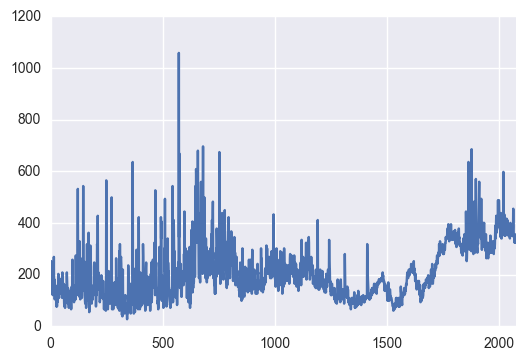

In [7]:
df.co_ppb.plot()

In [8]:
df.co_ppb.describe()

count    2077.000000
mean      204.902868
std       102.765262
min        27.328549
25%       126.169591
50%       180.948963
75%       263.288145
max      1058.099415
Name: co_ppb, dtype: float64

## One hour averages

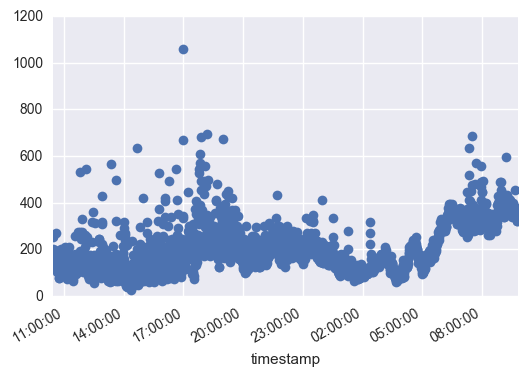

In [9]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_ppb.plot(linestyle='none', marker='o')
#ds = ds.set_coords(['timestamp','id'])
#ds = ds.set_coords(['timestamp','id'])

## Compare to kings measurements from MY1 station

In [10]:
# load kings

df_kings_vol = pd.read_csv('my1_volume_18jan.csv')
df_kings_vol['timestamp'] = pd.to_datetime(df_kings_vol.date)

def filter_by_time(df):
    time = (df.timestamp >= '2017-01-17 13:00') & (df.timestamp <= '2017-01-18 12:00')
    return df[time]

# co is in ppm
df_kings_vol.co = 1000 * df_kings_vol.co

df_kings_vol = filter_by_time(df_kings_vol)
df_kings_vol = df_kings_vol.set_index('timestamp')
ds_kings_vol = xr.Dataset.from_dataframe(df_kings_vol)
kings_prefix = dict([(v, 'kings_'+v) for v in ds_kings_vol.data_vars])


def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    #ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print(ds_merged_one.to_dataframe().describe())
    
    # calculate r2 score
    r2 = r2_score(ds_merged_one.to_dataframe().dropna()[airpublic_measure], ds_merged_one.to_dataframe().dropna()[kings_measure])
    print("r2 score: ", r2)
    
    # KS-test
    ks_statistic, p_value = scipy.stats.ks_2samp(ds_merged_one.to_dataframe().dropna()[airpublic_measure], ds_merged_one.to_dataframe().dropna()[kings_measure])
    print("Probability that they belong to the same distribution (KS p-value): ", p_value)    

In [11]:
ds_kings_vol.to_dataframe().head()

,Unnamed: 0,date,site,nox,no2,o3,so2,co,pm10_raw,pm10,nv10,code
timestamp,,,,,,,,,,,,
2017-01-17 13:00:00,9182,2017-01-17 13:00:00,Westminster - Marylebone Road,NaN,NaN,NaN,NaN,NaN,64.800450,63.372866,NaN,MY1
2017-01-17 14:00:00,9183,2017-01-17 14:00:00,Westminster - Marylebone Road,295.0899,57.658025,8.059500,5.34600,200.0,47.880333,48.438046,NaN,MY1
2017-01-17 15:00:00,9184,2017-01-17 15:00:00,Westminster - Marylebone Road,330.3483,64.011675,7.412750,5.46975,300.0,57.142215,54.528085,NaN,MY1
2017-01-17 16:00:00,9185,2017-01-17 16:00:00,Westminster - Marylebone Road,272.0574,62.759150,7.885375,4.95000,400.0,52.396728,50.716279,NaN,MY1
2017-01-17 17:00:00,9186,2017-01-17 17:00:00,Westminster - Marylebone Road,306.7182,73.067325,7.611750,4.77675,500.0,53.607645,52.445866,NaN,MY1


         kings_co  co_ppb_modified
count   19.000000        20.000000
mean   492.543860       495.656381
std    221.803333       230.260796
min    200.000000       200.000000
25%    345.833333       320.634188
50%    450.000000       469.834448
75%    537.500000       626.391321
max    950.000000       950.000000
r2 score:  0.930406891549
Probability that they belong to the same distribution (KS p-value):  0.956292329188


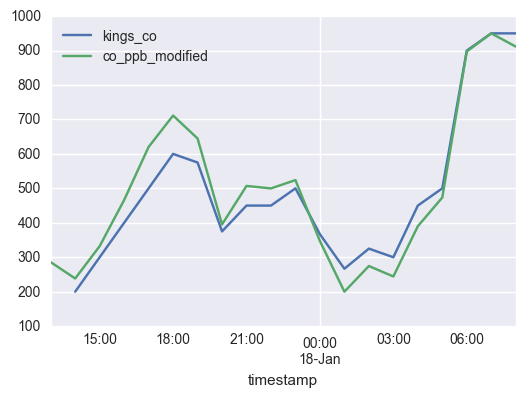

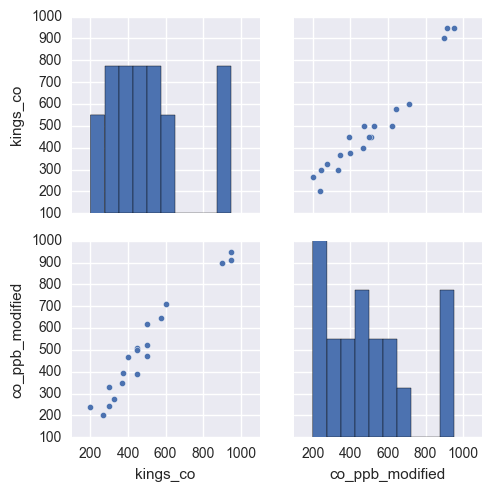

In [12]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
# normalization
kings_range = ds_merged['kings_co'].max() - ds_merged['kings_co'].min()
our_range = ds_merged['co_ppb'].max() - ds_merged['co_ppb'].min()
factor = kings_range / our_range
translation = ds_merged.kings_co.max() - ds_merged.co_ppb.max() * factor
ds_merged['co_ppb_modified'] = ds_merged['co_ppb'] * factor + translation

compare(ds_merged,'kings_co','co_ppb_modified')

## Fudge factors using linear regression

Coefficients: 
 [[ 2.92821216]] [-122.97492167]
Mean squared error: 1472.34
Variance score: 0.78


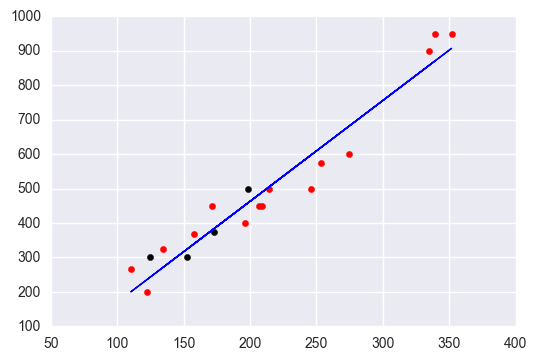

In [13]:
# drop nan values for our use
ds_merged_temp = ds_merged.to_dataframe().dropna(subset=['kings_co'])

# split the data into training and test sets
kings_train, kings_test, co_train, co_test = train_test_split(ds_merged_temp.kings_co, ds_merged_temp.co_ppb, test_size=0.2)

# convenience function for reshaping for use in sklearn linear regression
def reshape(xarray_col):
    return xarray_col.values.reshape((len(xarray_col.values), 1))

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(reshape(co_train), reshape(kings_train))
# co_train.values.shape
# The coefficients
print('Coefficients: \n', regr.coef_, regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(reshape(co_test)) - reshape(kings_test)) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reshape(co_test), reshape(kings_test)))


plt.scatter(co_test, kings_test,  color='black')
plt.scatter(co_train, kings_train, color='red')
plt.plot(reshape(co_train), regr.predict(reshape(co_train)), color='blue',
         linewidth=1)
plt.show()

         kings_co  co_ppb_modified
count   19.000000        20.000000
mean   492.543860       478.596197
std    221.803333       217.037855
min    200.000000       199.918158
25%    345.833333       313.624816
50%    450.000000       454.257112
75%    537.500000       601.823562
max    950.000000       906.848711
r2 score:  0.939505375876
Probability that they belong to the same distribution (KS p-value):  0.956292329188


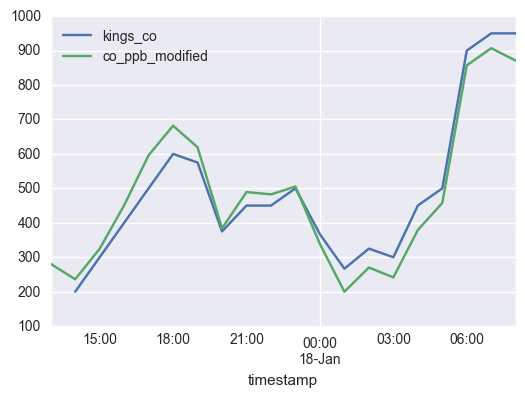

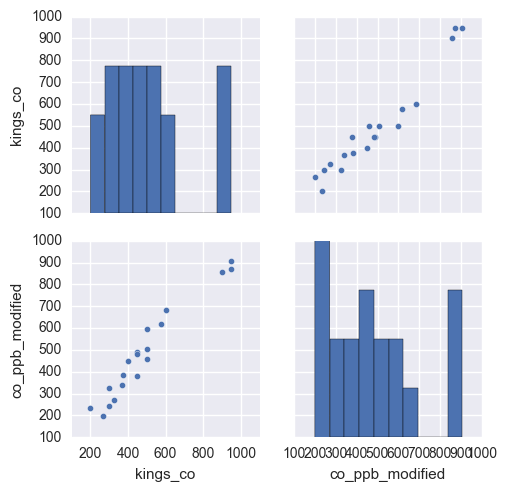

In [14]:
ds_merged['co_ppb_modified'] = ds_merged['co_ppb'] * regr.coef_[0] + regr.intercept_[0]

compare(ds_merged,'kings_co','co_ppb_modified')

## Fudge factors by fitting to the original formula

In [15]:
def convert_co_model(raw_CO, CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV, CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV, 
                     CO_SENSITIVITY, PCB_GAIN):
    CO_working_mv, CO_aux_mv = raw_CO
    temp_correction = 1
    scaled_working_CO_nA = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / PCB_GAIN
    scaled_aux_CO_nA  =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / PCB_GAIN * temp_correction
    return (scaled_working_CO_nA - scaled_aux_CO_nA) / CO_SENSITIVITY

In [16]:
packed = ds_merged_temp[['raw_CO_working', 'raw_CO_aux']].T.values
packed

array([[ 137.19690443,  142.36496162,  150.14517671,  159.48146272,
         165.20357025,  161.38895084,  145.65451852,  152.47808215,
         152.30270902,  154.34063536,  143.2085994 ,  133.90053147,
         138.51552181,  136.38534266,  145.44005328,  150.52144916,
         176.64937729,  179.67779189,  177.5814876 ],
       [ 108.83384349,  108.48573199,  108.40244603,  108.69531631,
         109.06657851,  109.15495219,  108.0740633 ,  108.34161347,
         108.58549836,  109.20620713,  108.46966367,  107.787338  ,
         108.02978355,  107.67685648,  108.17163636,  108.3519569 ,
         109.59425641,  109.52949252,  109.68224793]])

In [17]:
co_popt, co_pcov = spo.curve_fit(convert_co_model, packed, ds_merged_temp.kings_co.values)

# compare fitted values to the given values
print("CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV", co_popt[0], " | real: ", CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)
print("CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV", co_popt[1], " | real: ", CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV)
print("CO_SENSITIVITY", co_popt[2], " | real: ", CO_SENSITIVITY)
print("PCB_GAIN", co_popt[3], " | real: ", str(0.8))

CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV 43.4568312984  | real:  268
CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV 30.4094493093  | real:  262
CO_SENSITIVITY -0.266089934042  | real:  0.228
PCB_GAIN -0.23709211211  | real:  0.8


       co_ppb_modified    kings_co
count        19.000000   19.000000
mean        492.544273  492.543860
std         215.038165  221.803333
min         207.105120  200.000000
25%         337.017497  345.833333
50%         461.612213  450.000000
75%         609.668995  537.500000
max         905.102020  950.000000
r2 score:  0.936087941395
Probability that they belong to the same distribution (KS p-value):  0.956292329188


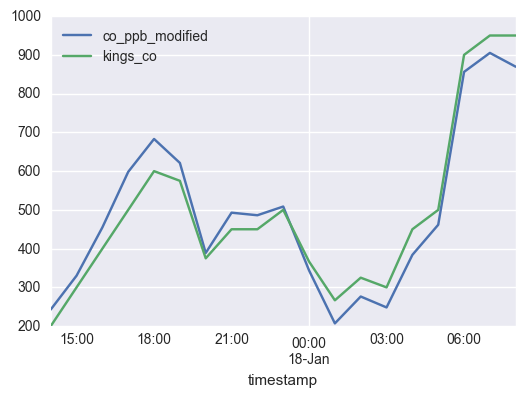

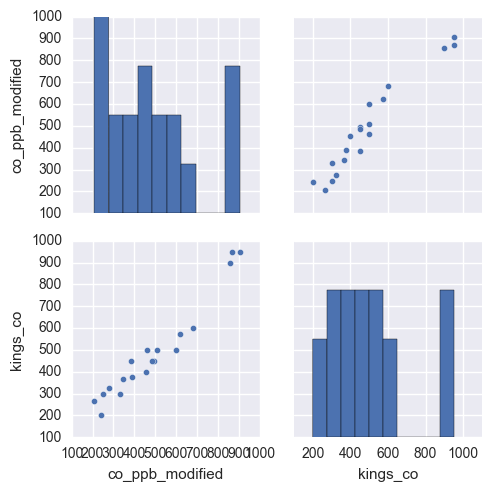

In [18]:
y = convert_co_model(packed, *co_popt)
y.shape
ds_merged_temp['co_ppb_modified'] = convert_co_model(packed, *co_popt)
compare(xr.Dataset.from_dataframe(ds_merged_temp), 'co_ppb_modified', 'kings_co')

## f1 score

In [19]:
# NO2 threshold taken from page 86 of http://www.euro.who.int/__data/assets/pdf_file/0009/128169/e94535.pdf
CO_WHO_THRESHOLD_MICROGRAMS = 10.5 * 10**3 # in micrograms per m3
CO_WHO_THRESHOLD_PPB = CO_WHO_THRESHOLD_MICROGRAMS / 1.145 # convert to ppb
CO_WHO_THRESHOLD_PPB

9170.305676855894

All the readings seem to be well below the threshold...I'll try setting a lower threshold to see the f1 score

In [20]:
CO_WHO_THRESHOLD_PPB = 500

In [22]:
# f1 score without any scaling or translation
# f1_score(co_r2_df.dropna()['kings_co'] > CO_WHO_THRESHOLD_PPB, co_r2_df.dropna()['co_ppb'] > CO_WHO_THRESHOLD_PPB)

In [23]:
# f1 score after some normalization
# f1_score(co_r2_df.dropna()['kings_co'] > CO_WHO_THRESHOLD_PPB, co_r2_df.dropna()['co_ppb_modified'] > CO_WHO_THRESHOLD_PPB)

# NO2 conversion

In [24]:
# AFE board serial number 12-000027
# sensor NO2 A43F serial number 212060336
NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 2;
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 0;
NO2_SENSITIVITY = 0.197; # mv/ppb

def convert_no2(NO2_working_mv=None, NO2_aux_mv=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C    
    
    scaled_working_NO2_nA = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8
    scaled_aux_NO2_nA = (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8 * temp_correction
    return (scaled_working_NO2_nA -  scaled_aux_NO2_nA ) / NO2_SENSITIVITY

In [25]:
df['no2_ppb'] = df[['raw_NO2_working','raw_NO2_aux']].apply(lambda x: convert_no2(x.values[0], x.values[1]), axis=1)

In [26]:
df.no2_ppb.describe()

count    2077.000000
mean      128.640266
std        10.240371
min        97.653946
25%       123.620166
50%       129.353684
75%       135.654253
max       193.887264
Name: no2_ppb, dtype: float64

## One hour averages

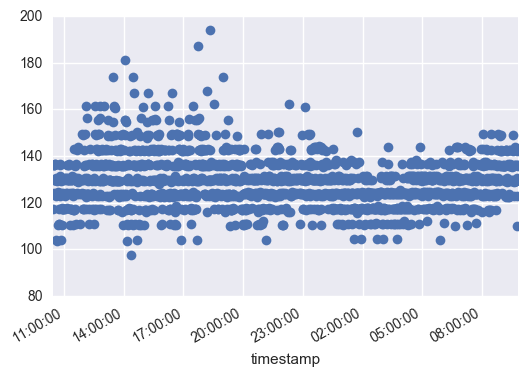

In [27]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').no2_ppb.plot(linestyle='none', marker='o')

## Compare to Kings

       kings_no2  no2_ppb_modified
count  19.000000         20.000000
mean   52.392931         56.730012
std     9.749879         10.711537
min    36.768175         36.768175
25%    45.259812         48.659768
50%    51.498600         57.458254
75%    58.665725         64.878006
max    73.067325         73.067325
r2 score:  0.560046709477
Probability that they belong to the same distribution (KS p-value):  0.741505714203


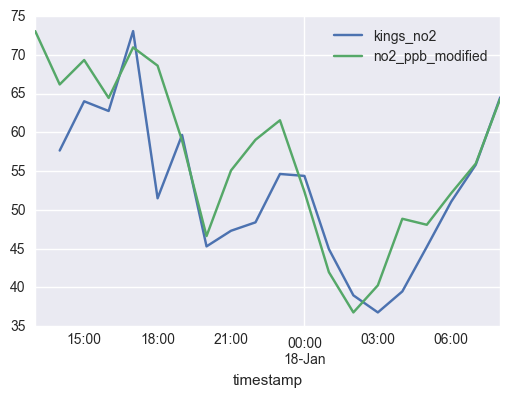

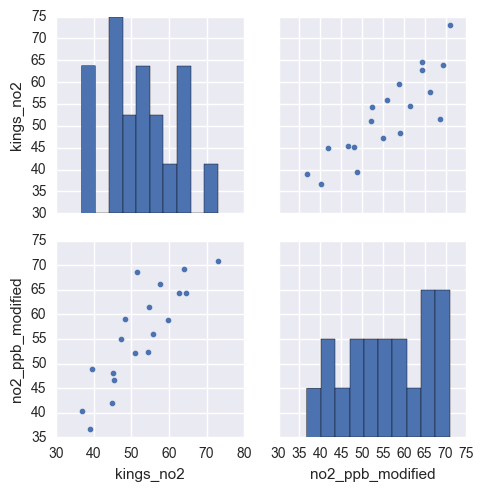

In [28]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
# normalization for better comparison
kings_range = ds_merged['kings_no2'].max() - ds_merged['kings_no2'].min()
our_range = ds_merged['no2_ppb'].max() - ds_merged['no2_ppb'].min()
factor = kings_range / our_range
translation = ds_merged.kings_no2.max() - ds_merged.no2_ppb.max() * factor
ds_merged['no2_ppb_modified'] = ds_merged['no2_ppb'] * factor + translation
compare(ds_merged,'kings_no2','no2_ppb_modified')

## Fudge factors using linear regression

Coefficients: 
 [[ 2.05990313]] [-212.26221981]
Mean squared error: 14.54
Variance score: 0.86


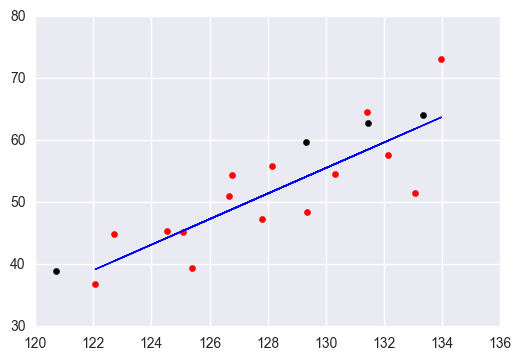

In [29]:
# drop nan values for our use
ds_merged_temp = ds_merged.to_dataframe().dropna(subset=['kings_no2'])

# split the data into training and test sets
kings_train, kings_test, no2_train, no2_test = train_test_split(ds_merged_temp.kings_no2, ds_merged_temp.no2_ppb, test_size=0.2)

# convenience function for reshaping for use in sklearn linear regression
def reshape(xarray_col):
    return xarray_col.values.reshape((len(xarray_col.values), 1))

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(reshape(no2_train), reshape(kings_train))
# co_train.values.shape
# The coefficients
print('Coefficients: \n', regr.coef_, regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(reshape(no2_test)) - reshape(kings_test)) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reshape(no2_test), reshape(kings_test)))


plt.scatter(no2_test, kings_test,  color='black')
plt.scatter(no2_train, kings_train, color='red')
plt.plot(reshape(no2_train), regr.predict(reshape(no2_train)), color='blue',
         linewidth=1)
plt.show()

       kings_no2  no2_ppb_modified
count  19.000000         20.000000
mean   52.392931         52.344242
std     9.749879          8.561950
min    36.768175         36.388339
25%    45.259812         45.893532
50%    51.498600         52.926342
75%    58.665725         58.857100
max    73.067325         65.402990
r2 score:  0.726987119354
Probability that they belong to the same distribution (KS p-value):  0.956292329188


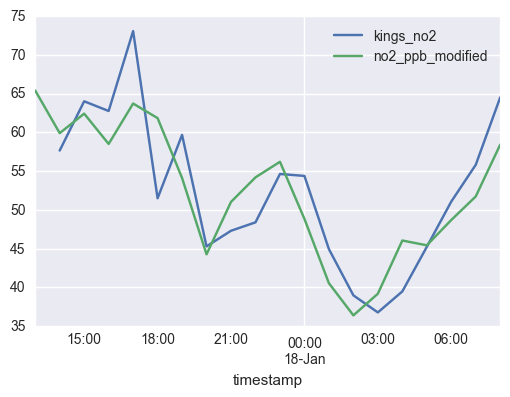

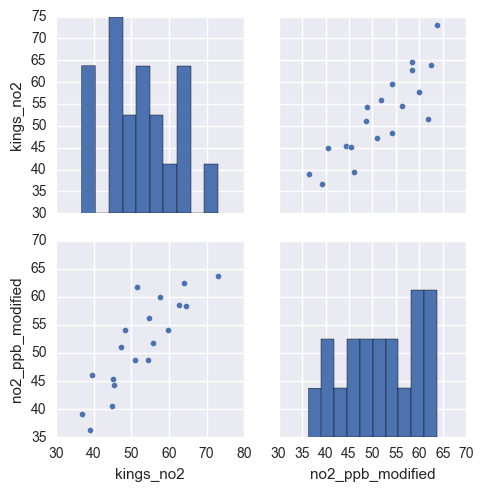

In [30]:
ds_merged['no2_ppb_modified'] = ds_merged['no2_ppb'] * regr.coef_[0] + regr.intercept_[0]
compare(ds_merged,'kings_no2','no2_ppb_modified')

## Fudge factors by fitting to the original formula

In [41]:
def convert_no2_model(raw_NO2, NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV, NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV, 
                     NO2_SENSITIVITY):
    NO2_PCB_GAIN= 0.8
    NO2_working_mv, NO2_aux_mv = raw_NO2
    temp_correction = 1.09
    scaled_working_NO2_nA = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_PCB_GAIN
    scaled_aux_NO2_nA  =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_PCB_GAIN * temp_correction
    return (scaled_working_NO2_nA - scaled_aux_NO2_nA) / NO2_SENSITIVITY

In [42]:
packed = ds_merged_temp[['raw_NO2_working', 'raw_NO2_aux']].T.values
packed

array([[ 128.69153247,  128.88919057,  128.47068437,  128.65093905,
         128.54444077,  128.13274074,  126.84877576,  127.31491987,
         127.556977  ,  127.84791742,  127.08204862,  126.43586813,
         125.94995405,  126.12692907,  126.43552714,  126.4384862 ,
         127.08102564,  127.47248485,  128.29478788],
       [ 123.31988012,  123.3244229 ,  123.21505754,  123.01458086,
         123.04890358,  123.21340337,  122.72691717,  122.67968215,
         122.67961154,  122.80532268,  122.61982284,  122.60959307,
         122.45512354,  122.4213653 ,  122.22256677,  122.26870303,
         122.62902964,  122.77457174,  123.05983471]])

In [43]:
no2_popt, no2_pcov = spo.curve_fit(convert_no2_model, packed, ds_merged_temp.kings_no2.values)

# compare fitted values to the given values
print("NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV", no2_popt[0], " | real: ", NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)
print("NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV", no2_popt[1], " | real: ", NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV)
print("NO2_SENSITIVITY", no2_popt[2], " | real: ", NO2_SENSITIVITY)
# print("NO2_PCB_GAIN", no2_popt[3], " | real: ", str(0.8))

NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV -11.2687323942  | real:  295
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV -0.88873313301  | real:  295
NO2_SENSITIVITY 0.0940503709751  | real:  0.197


       no2_ppb_modified  kings_no2
count         19.000000  19.000000
mean          52.392931  52.392931
std            8.348559   9.749879
min           36.866982  36.768175
25%           46.375122  45.259812
50%           52.474739  51.498600
75%           59.315730  58.665725
max           64.660287  73.067325
r2 score:  0.63612211199
Probability that they belong to the same distribution (KS p-value):  0.999820414312


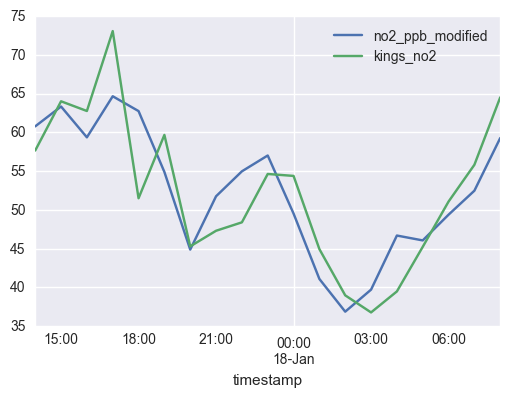

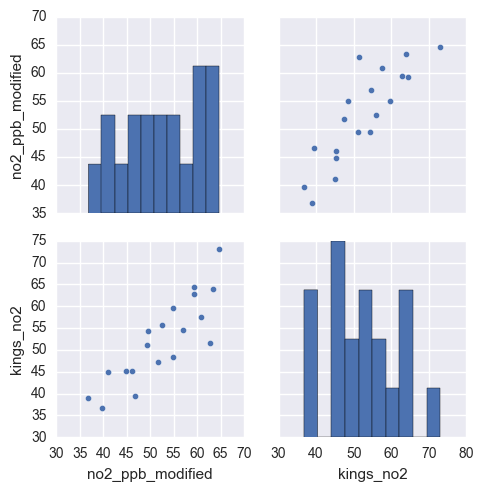

In [44]:
y = convert_no2_model(packed, *no2_popt)
y
ds_merged_temp['no2_ppb_modified'] = convert_no2_model(packed, *no2_popt)
compare(xr.Dataset.from_dataframe(ds_merged_temp), 'no2_ppb_modified', 'kings_no2')

## f1 score

In [35]:
# NO2 threshold taken from page 17 of http://apps.who.int/iris/bitstream/10665/69477/1/WHO_SDE_PHE_OEH_06.02_eng.pdf
NO2_WHO_THRESHOLD_MICROGRAMS = (40 + 200) / 2. # in micrograms per m3
NO2_WHO_THRESHOLD_PPB = NO2_WHO_THRESHOLD_MICROGRAMS / 1.88
NO2_WHO_THRESHOLD_PPB

63.829787234042556

In [37]:
# f1 score without any scaling or translation
# f1_score(no2_r2_df.dropna()['kings_no2'] > NO2_WHO_THRESHOLD_PPB, no2_r2_df.dropna()['no2_ppb'] > NO2_WHO_THRESHOLD_PPB)

In [38]:
# f1 score after some normalization
# f1_score(no2_r2_df.dropna()['kings_no2'] > NO2_WHO_THRESHOLD_PPB, no2_r2_df.dropna()['no2_ppb_modified'] > NO2_WHO_THRESHOLD_PPB)